In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings('ignore')
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.dummy import DummyClassifier


from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

from sklearn.preprocessing import MinMaxScaler

from sklearn.pipeline import Pipeline

#from avi proj ,do we need?
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, fbeta_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
import sklearn

In [96]:
# Load the dataset into a DataFrame
df = pd.read_csv("train.csv")

# Display the first few rows of the dataset to get an overview
df.head(3)

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0


In [97]:
# Check the data types and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  KPIs_met >80%         54808 non-null  int64  
 11  awards_won?           54808 non-null  int64  
 12  avg_training_score    54808 non-null  int64  
 13  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.9+ MB


In [98]:
# Get summary statistics for numerical columns
df.describe()

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
count,54808.000000,54808.000000,54808.000000,50684.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000
mean,39195.830627,1.253011,34.803915,3.329256,5.865512,0.351974,0.023172,63.386750,0.085170
std,22586.581449,0.609264,7.660169,1.259993,4.265094,0.477590,0.150450,13.371559,0.279137
min,1.000000,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000
25%,19669.750000,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000
50%,39225.500000,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000
75%,58730.500000,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000
max,78298.000000,10.000000,60.000000,5.000000,37.000000,1.000000,1.000000,99.000000,1.000000


In [99]:
# Check for missing values in each column
df.isnull().sum()

employee_id                0
department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
is_promoted                0
dtype: int64

In [100]:
# only 6000 rows with nan, for now we will drop them and later see what to do.
df.dropna(inplace=True)

# Replace 'f' with 'female' and 'm' with 'male' in the 'gender' column
df['gender'] = df['gender'].replace({'f': 'female', 'm': 'male'})

In [101]:
#extract the number from the region
df['region'] = df['region'].str.extract('(\d+)').astype(int)

*The plot below reveals that the data is imbalanced, with an unequal distribution between the classes. To improve model performance, we will later apply techniques to balance the class distribution.*

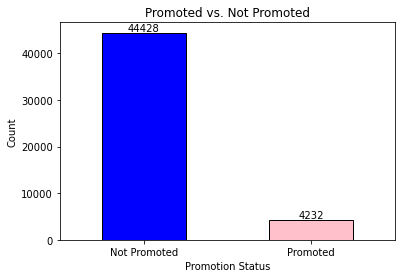

In [102]:
# Count the number of promoted and not-promoted employees
promotion_counts = df['is_promoted'].value_counts()

# Plot a bar chart
plt.figure(figsize=(6, 4))
promotion_counts.plot(kind='bar', color=['blue', 'pink'], linewidth=1, edgecolor="black")
plt.title("Promoted vs. Not Promoted")
plt.xlabel("Promotion Status")
plt.ylabel("Count")

# Add labels to the bars
for i, count in enumerate(promotion_counts):
    plt.text(i, count, str(count), ha='center', va='bottom', fontsize=10)

# Set custom labels and positions for x-axis ticks
plt.xticks(ticks=[0, 1], labels=['Not Promoted', 'Promoted'], rotation=0)

plt.show()

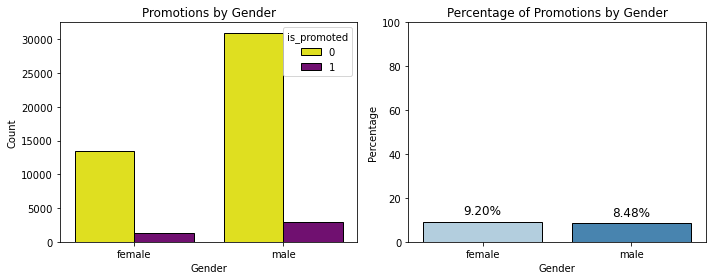

In [103]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Create a DataFrame with promotions and not promoted counts by gender
gender_counts = df.groupby(['gender', 'is_promoted'])['employee_id'].count().reset_index()

sns.barplot(x='gender', y='employee_id', hue='is_promoted', data=gender_counts,ax=axes[0] ,palette=["yellow","purple"], linewidth=1, edgecolor="black")
axes[0].set_title("Promotions by Gender")
axes[0].set_xlabel("Gender")
axes[0].set_ylabel("Count")

# Calculate the percentage of promotions by gender
gender_promotion_count = df.groupby('gender')['is_promoted'].value_counts().unstack()
promotion_percentages = gender_promotion_count[1] / (gender_promotion_count[1] + gender_promotion_count[0]) * 100

# Plot a bar chart
sns.barplot(x=promotion_percentages.index, y=promotion_percentages.values, ax=axes[1],palette="Blues",linewidth=1, edgecolor="black")
axes[1].set_title("Percentage of Promotions by Gender")
axes[1].set_xlabel("Gender")
axes[1].set_ylabel("Percentage")
plt.ylim(0, 100)  # Set the y-axis limit to show percentages

# Annotate the bars with percentage values
for index, value in enumerate(promotion_percentages):
    plt.text(index, value + 2, f"{value:.2f}%", ha='center', va='bottom', fontsize=12)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

TypeError: bar() got multiple values for argument 'width'

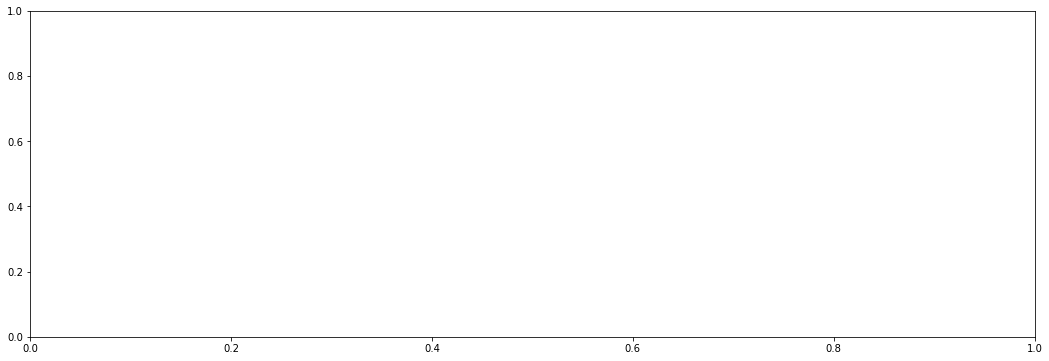

In [104]:
plt.figure(figsize=(18, 6))

score_counts = df.groupby(['avg_training_score', 'is_promoted'])['is_promoted'].count().unstack().fillna(0)

sns.barplot(data=score_counts.reset_index(), x='avg_training_score', y=1, color='red', label='Promoted',linewidth=1, edgecolor="black")
sns.barplot(data=score_counts.reset_index(), x='avg_training_score', y=0, color='yellow', bottom=score_counts[1], label='Not Promoted',linewidth=1, edgecolor="black")
plt.title("Count of Promoted vs. Not Promoted by 'avg_training_score'")
plt.xlabel("Average Training Score")
plt.ylabel("Count")
plt.legend(title="Promotion Status")
plt.show()

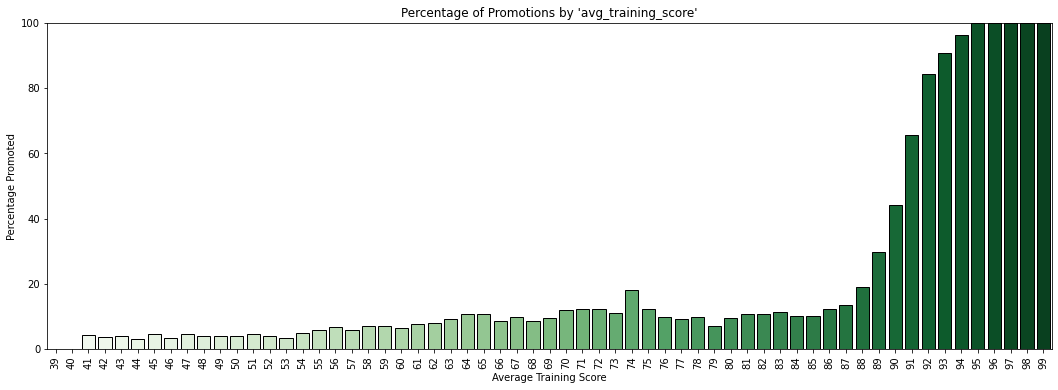

In [105]:
# Group the data by 'avg_training_score' and calculate the percentage of promotions
score_promotion_percentage = df.groupby('avg_training_score')['is_promoted'].mean() * 100

# Plot a bar chart for the percentage of promotions
plt.figure(figsize=(18, 6))
sns.barplot(x=score_promotion_percentage.index, y=score_promotion_percentage.values, palette='Greens',linewidth=1, edgecolor="black")
plt.title("Percentage of Promotions by 'avg_training_score'")
plt.xlabel("Average Training Score")
plt.ylabel("Percentage Promoted")
plt.ylim(0, 100)  # Set the y-axis limit to show percentages
plt.xticks(rotation=90)

plt.show()

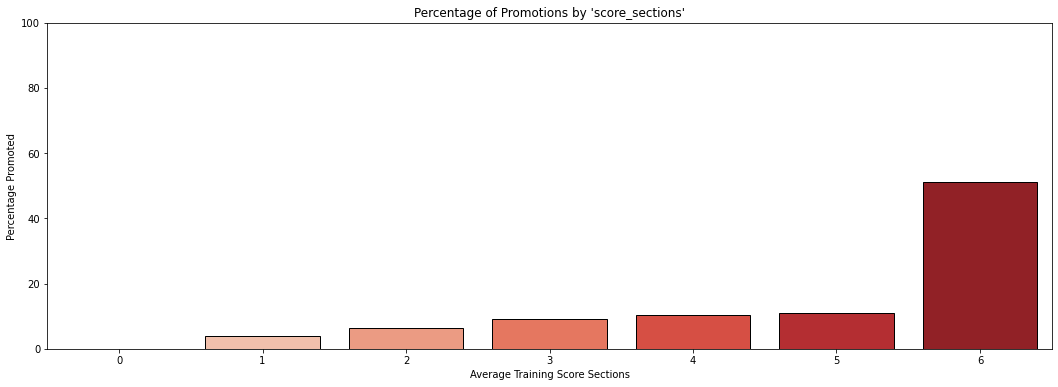

In [106]:
# We will attempt to partition the column into multiple segments.

# Define the bin edges and labels
bin_edges = [0, 40, 53, 60, 70 ,80,87,99]  # Adjust the bin edges as needed
bin_labels = [0, 1, 2, 3, 4, 5, 6]  # Numeric labels for each bin

# Use pd.cut to create sections and map them to numerical values
df['score_sections'] = pd.cut(df['avg_training_score'], bins=bin_edges, labels=bin_labels, include_lowest=True)

# Group the data by 'score_sections' and calculate the percentage of promotions
score_promotion_percentage = df.groupby('score_sections')['is_promoted'].mean() * 100

# Plot a bar chart for the percentage of promotions
plt.figure(figsize=(18, 6))
sns.barplot(x=score_promotion_percentage.index, y=score_promotion_percentage.values, palette='Reds',linewidth=1, edgecolor="black")
plt.title("Percentage of Promotions by 'score_sections'")
plt.xlabel("Average Training Score Sections")
plt.ylabel("Percentage Promoted")
plt.ylim(0, 100)  # Set the y-axis limit to show percentages

plt.show()

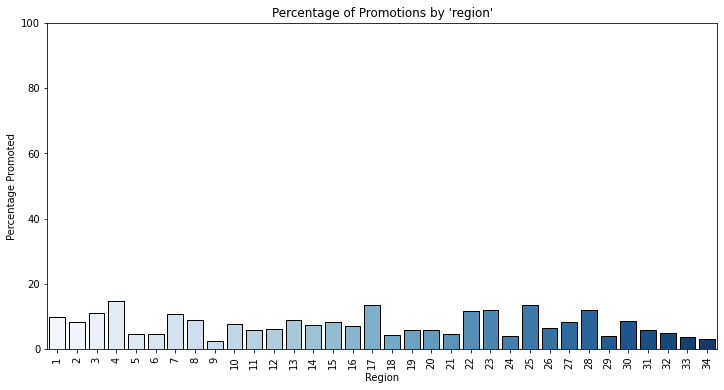

In [107]:
# Group the data by 'region' and calculate the percentage of promotions
region_promotion_percentage = df.groupby('region')['is_promoted'].mean() * 100

# Sort regions by promotion percentage in descending order
region_promotion_percentage = region_promotion_percentage.sort_values(ascending=False)

# Plot a bar chart for the percentage of promotions by region
plt.figure(figsize=(12, 6))
sns.barplot(x=region_promotion_percentage.index, y=region_promotion_percentage.values, palette='Blues',linewidth=1, edgecolor="black")
plt.title("Percentage of Promotions by 'region'")
plt.xlabel("Region")
plt.ylabel("Percentage Promoted")
plt.ylim(0, 100)  # Set the y-axis limit to show percentages
plt.xticks(rotation=90)

plt.show()

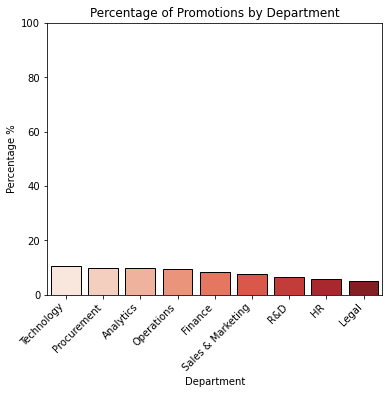

In [108]:
# Calculate the percentage of promotions for each department
department_promotion_percentage = df.groupby('department')['is_promoted'].mean() * 100

# Sort departments by promotion percentage
department_promotion_percentage = department_promotion_percentage.sort_values(ascending=False)

# Plot a bar chart
plt.figure(figsize=(6, 5))
ax = sns.barplot(y=department_promotion_percentage.values, x=department_promotion_percentage.index, palette="Reds", linewidth=1, edgecolor="black")
plt.title("Percentage of Promotions by Department")
plt.xlabel("Department")
plt.ylabel("Percentage %")
plt.ylim(0, 100)  # Set the y-axis limit to show percentages

# Rotate x-axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

In [109]:
# rating of departments based on their promotion performance

df['department'] = df['department'].map({'Technology':2, 'Procurement':2, 'Analytics':2 ,
                                        'Operations':2, 'Finance':1,'Sales & Marketing':1,
                                         'R&D':0, 'HR':0, 'Legal':0})

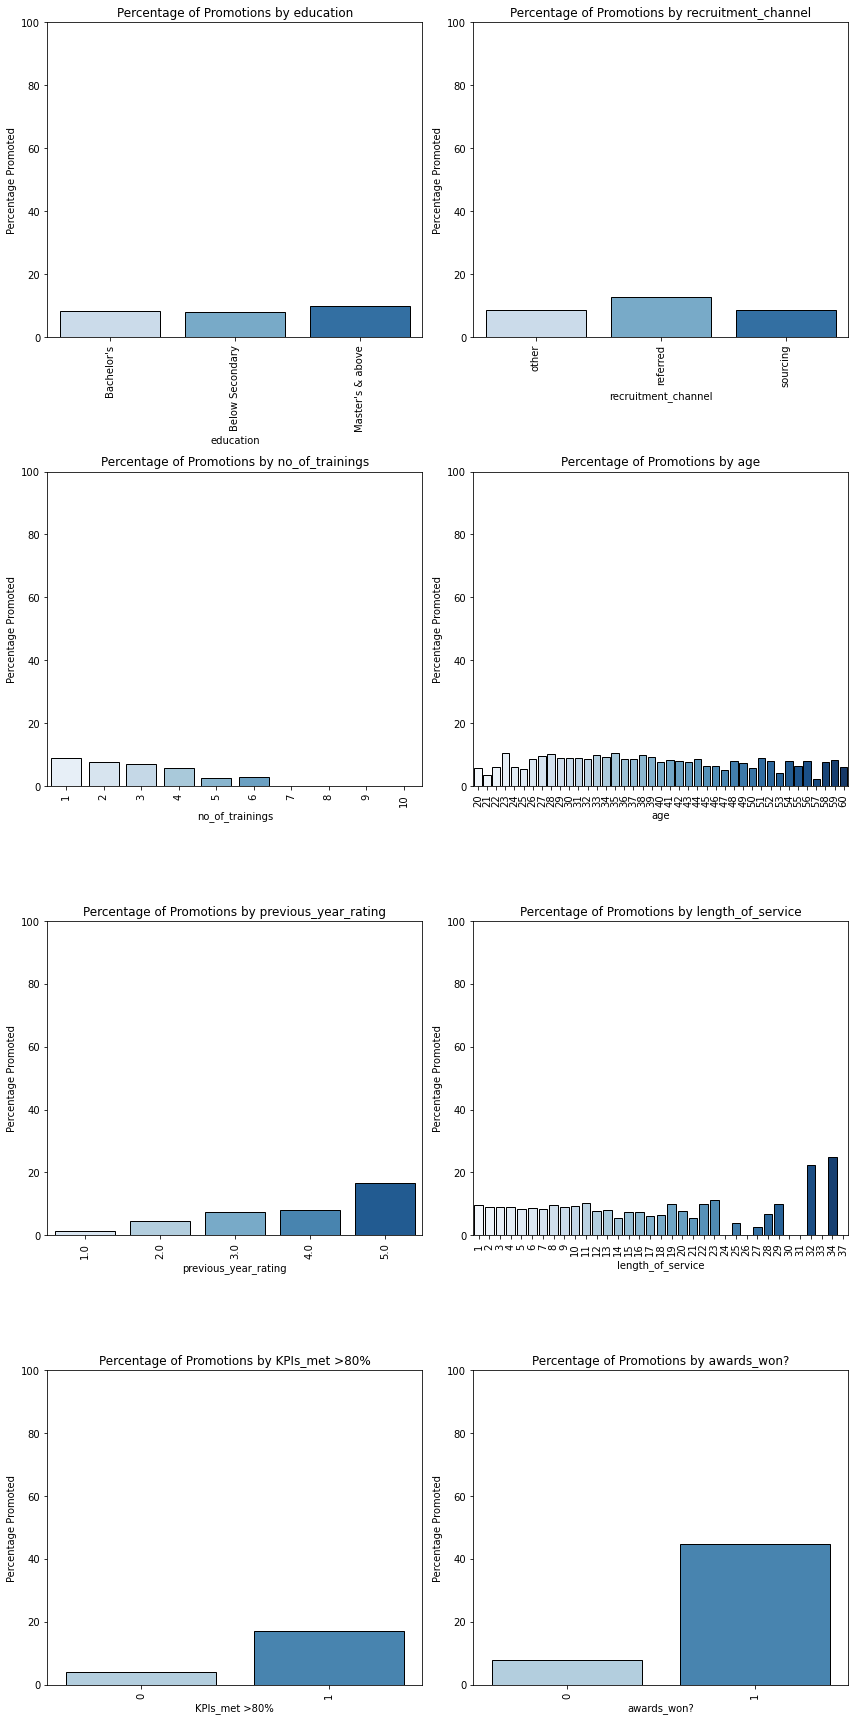

In [110]:
# Specify the columns you want to plot
columns = ['education', 'recruitment_channel', 'no_of_trainings', 'age', 'previous_year_rating',
           'length_of_service', 'KPIs_met >80%', 'awards_won?']

# Determine the number of rows and columns for subplots
n_rows = len(columns) // 2  # Divide by 2 to have two plots in each row
n_cols = 2  # Two plots in each row

# Create subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 6 * n_rows))

# Iterate through the specified columns and create plots in rows with two plots in each row
for i, col in enumerate(columns):
    row_index = i // 2  # Determine the row index
    col_index = i % 2   # Determine the column index

    # Group the data by the specified column and calculate the percentage of promotions
    promotion_percentage = df.groupby(col)['is_promoted'].mean() * 100

    # Plot the percentage of promotions on the current axis
    sns.barplot(x=promotion_percentage.index, y=promotion_percentage.values, palette='Blues', ax=axes[row_index, col_index], linewidth=1, edgecolor="black")
    axes[row_index, col_index].set_title("Percentage of Promotions by " + col)
    axes[row_index, col_index].set_xlabel(col)
    axes[row_index, col_index].set_ylabel("Percentage Promoted")
    axes[row_index, col_index].set_ylim(0, 100)  # Set the y-axis limit to show percentages
    axes[row_index, col_index].tick_params(axis='x', rotation=90)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

In [111]:
# rating of no_of_trainings based on their promotion performance

df['no_of_trainings'] = df['no_of_trainings'].map({1:2, 2:2, 3:2 ,4:2, 
                                                   5:1,6:1,
                                                   7:0, 8:0, 9:0, 10:0})

In [112]:
# Encode categorical variables
df = pd.get_dummies(df, columns=['region', 'education', 'gender', 'recruitment_channel'], drop_first=True)

In [119]:
X = df.drop(columns=['employee_id', 'is_promoted', 'age'])
y = df['is_promoted']

In [120]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=25)

In [123]:
train_set.to_csv('train_set_HR.csv')
test_set.to_csv('test_set_HR.csv')

In [124]:
df2 = pd.read_csv('train_set_HR.csv',index_col=0)

In [125]:
X = df2.drop(['is_promoted'], axis=1)
y = df2['is_promoted'].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25)

X_train

,employee_id,department,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,score_sections,...,region_30,region_31,region_32,region_33,region_34,education_Below Secondary,education_Master's & above,gender_male,recruitment_channel_referred,recruitment_channel_sourcing
13524,29249,2,2,36,4.0,3,0,0,80,4,...,0,0,0,0,0,0,1,0,1,0
47987,67222,1,2,33,1.0,4,0,0,50,1,...,0,0,0,0,0,0,0,1,0,0
15002,44050,2,2,36,3.0,7,0,0,60,2,...,0,0,0,0,0,0,0,1,0,1
14775,45636,2,2,41,5.0,9,0,0,74,4,...,0,0,0,0,0,0,0,1,0,0
23742,54488,2,2,34,5.0,7,1,0,86,5,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33231,61366,1,2,37,3.0,7,0,0,50,1,...,0,0,0,0,0,0,1,0,0,1
2920,31852,2,2,30,1.0,2,0,0,85,5,...,0,0,0,0,0,0,0,1,0,0
22378,8987,1,2,32,2.0,5,1,0,49,1,...,0,0,0,0,0,0,0,0,0,1
22278,7422,2,2,48,2.0,3,0,0,80,4,...,0,0,0,0,0,0,1,1,0,0


In [129]:
standard = StandardScaler()

X_test_stand = X_test.copy()
X_train_stand = X_train.copy()
y_train_stand = y_train.copy()
y_test_stand = y_test.copy()


X_train_stand = standard.fit_transform(X_train_stand)
X_test_stand = standard.transform(X_test_stand)

In [130]:
#split it again since we cant use the real train

In [131]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train_stand,y_train, test_size=0.2, random_state=25)

In [133]:
X_test2_stand = X_test2.copy()
X_train2_stand = X_train2.copy()
y_train2_stand = y_train2.copy()
y_test2_stand = y_test2.copy()

X_train2_stand = standard.fit_transform(X_train2_stand)
X_test2_stand = standard.transform(X_test2_stand)

In [134]:
def confusion_matrix_show(cf_matrix):
    group_names = ['True Neg','False Pos','False Neg','True Pos']

    group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)

    ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

    ax.set_title('Model Confusion Matrix\n\n');
    ax.set_xlabel('\nPredictions')
    ax.set_ylabel('Actual');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])
    
    
    ## Display the visualization of the Confusion Matrix.
    plt.show()

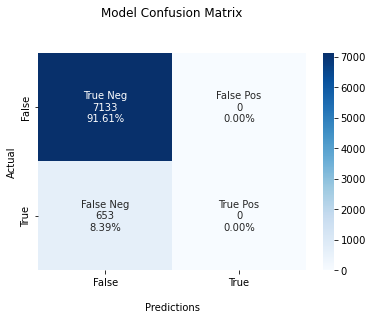

Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Accuracy:0.9116627131032533


In [144]:
dummy_model = DummyClassifier(strategy="most_frequent")

dummy_model.fit(X_train, y_train)

y_predict = dummy_model.predict(X_test)

confusion_matrix_show(confusion_matrix(y_test, y_predict))

y_train_pred = cross_val_predict(dummy_model, X_train, y_train, cv=10)

accuracy = np.mean(cross_val_score(dummy_model, X_train, y_train, scoring='accuracy', cv=10))

f1 = np.mean(cross_val_score(dummy_model, X_train, y_train, scoring='f1', cv=10))

precision = precision_score(y_train, y_train_pred)

recall = recall_score(y_train, y_train_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy:{accuracy}")

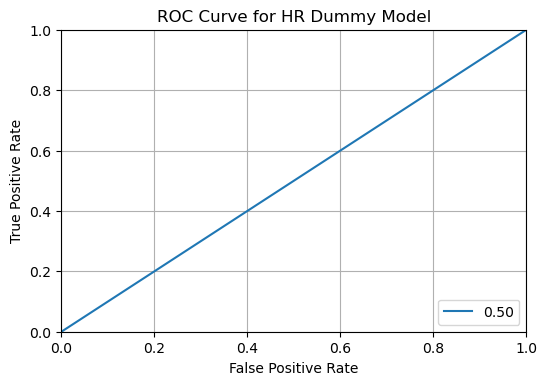

In [149]:
plt.figure(dpi=100)
fpr, tpr, thresholds = roc_curve(y_test, y_predict)
plt.plot(fpr,tpr,label = "%.2f" %sklearn.metrics.roc_auc_score(y_test,y_predict))
plt.legend(loc = 'lower right')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC Curve for HR Dummy Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

In [150]:
def roc_show(y_test,y_predict):
    plt.figure(dpi=100)
    fpr, tpr, thresholds = roc_curve(y_test, y_predict)
    plt.plot(fpr,tpr,label = "%.2f" %sklearn.metrics.roc_auc_score(y_test,y_predict))
    plt.plot([0, 1], [0, 1], color='crimson', linestyle='--')
    plt.legend(loc = 'lower right')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title('ROC Curve for HR for Model')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)